# What's fit.py doing? The fitting procedure in detail

To give further insight into the fitting process in <font color=green>Frankenstein</font> (`frank`) and how you can modify it, here we'll use the code as a module and perform the same fit that's in the [Quickstart](../quickstart.rst), just in more detail.

So we'll keep using the DSHARP continuum observations of AS 209 ([Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract)) as the input dataset, and frank will reconstruct the disc's 1D radial brightness profile by nonparametrically fitting the real component of the visibility distribution. 

Specifically frank will perform 4 steps in the fit, which we'll break into distinct calls here (these are the steps taken in `fit.py`): 

1. Parse the *.json* parameter file and read in the data (UVTable); 

2. Determine the disc geometry (inclination, position angle and phase offset), then deproject the visibilities;

3. Fit the deprojected visibilities with a Gaussian process (it'll take ~50 sec for this dataset) to yield a brightness profile;

4. Save the fit results and diagnostic figures. We'll also supply a CLEAN brightness profile for the disc as well as the synthesized CLEAN beam parameters, in order to compare the frank fit to the CLEAN fit by:

    - Convolving the fitted frank brightness profile with the synthesized beam to compare to the CLEAN profile and
    
    - Taking the discrete Hankel transform of the CLEAN profile to compare to the frank visibility domain fit.
    
Let's walk through these.

## 1. Read in the parameter values and data

As in the second example in the [Quickstart](../quickstart.rst) - where we use frank as a module - we'll import the internal classes [FrankFitter](../py_API.rst#frank.radial_fitters.FrankFitter) and [FitGeometryGaussian](../py_API.rst#frank.geometry.FitGeometryGaussian) directly, in order to demonstrate their usage. Just note that `fit.py` uses the wrapper functions `deproject_disc` and `perform_fit` to call these, and more generally uses wrapper functions to do everything that we'll walk through more verbosely here.

In [1]:
%matplotlib inline

import numpy as np

import frank
from frank.geometry import FitGeometryGaussian, FixedGeometry
from frank.radial_fitters import FrankFitter
from frank.fit import load_default_parameters
from frank.utilities import convolve_profile 
from frank.make_figs import make_deprojection_fig, make_clean_comparison_fig

frank.enable_logging()

Using a UVTable extracted from an MSTable (see [this tutorial](./mstable_to_uvtable.rst) for how to do this) and the default parameter file `default_parameters.json`, let's read both in.

In [2]:
model = load_default_parameters()

as209_dat = np.load('AS209_continuum.npz')
u, v, vis, weights = [as209_dat[k] for k in ['u', 'v', 'V', 'weights']]

## 2. Determinine the disc geometry and deproject the visibilities

Before fitting the radial brightness profile, we need to determine the disc's geometry (inclination, position angle and phase center) in order to deproject the visibilities (recall that frank, fitting in 1D, assumes an axisymmetric source).
To do this we pass an object specifying how the geometry is determined to the [FrankFitter](../py_API.rst#frank.radial_fitters.FrankFitter) class. **The position angle (PA) is defined positive east of north, and the right ascension offset (dRA) is defined positive for offsets toward east.**

frank has three classes for this: [FixedGeometry](../py_API.rst#frank.geometry.FixedGeometry) just takes a geometry you provide, [FitGeometryGaussian](../py_API.rst#frank.geometry.FitGeometryGaussian) determines the geometry by fitting a 2D Gaussian directly to the visibilities, and [FitGeometryFourierBessel](../py_API.rst#frank.geometry.FitGeometryFourierBessel) determines the geometry by fitting a nonparametric form. 

`FitGeometryFourierBessel` is a more robust approach than `FitGeometryGaussian`, as the former fits for the geometry without making any assumptions about the functional form of the visibilities. **Note that as `FitGeometryGaussian` fits a 2D Gaussian to the visibilities to determine the geometry, it is not a good choice for a highly non-Gaussian disc (like a disc with an inner cavity).**  There is a tradeoff in speed for using `FitGeometryFourierBessel`; even for large datasets (of order $10^7$ visibilities), `FitGeometryGaussian` takes only $\approx 30$ sec, while `FitGeometryFourierBessel` takes $> 10$ min. It's also useful to determine the geometry in the image plane and compare to the result from `frank`. You can also supply your own geometry fitting routine (see Sec.2.1 below).

For `FitGeometryGaussian` and `FitGeometryFourierBessel` you can choose to provide a known phase center if you _just_ want to fit for the inclination and PA (if running frank from the terminal, set `geometry : fit_phase_offset` to `false` in your parameter file and specify `dra` and `ddec` there). You can conversely supply the phase center and just fit for inclination and PA.

You can also supply an initial guess for the source geometry; if running frank from the terminal, setting `geometry : initial_guess` to `true` in your parameter file will use the `inc`, `pa`, and optionally `dra` and `ddec` in that file as the initial guess for the geometry solver. 

Here let's assume we don't know or have a guess on any of the disc's geometry parameters, and so fit for them all.

In [3]:
geom = FitGeometryGaussian()
geom.fit(u, v, vis, weights)

print('Fitted geometry: inc  = {:.2f} deg,\n\t\t PA   = {:.2f} deg,\n\t\t' 
      ' dRA  = {:.2e} mas,\n\t\t dDec = {:.2e} mas'.format(geom.inc, geom.PA,
                                                           geom.dRA*1e3,
                                                           geom.dDec*1e3))

    Fitting Gaussian to determine geometry


Fitted geometry: inc  = 33.93 deg,
		 PA   = 86.47 deg,
		 dRA  = -8.63e-01 mas,
		 dDec = 2.29e-01 mas


The published values ([Huang et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..42H/abstract)) are a bit different:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; inc  = 34.97 deg,  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; PA   = 85.76 deg,     
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; dRA  = 1.90 mas,     
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; dDec = 2.50 mas     

So let's use those. 

In [4]:
geom = FixedGeometry(34.97, 85.76, 1.9e-3, 2.5e-3)

Using the published geometry, we'll plot the deprojected (u, v) coordinates and visibilities - unbinned - just to see roughly how much the correction is affecting the (u,v) coordinates and visibility amplitudes. Note that `FrankFitter` (which we'll use below) deprojects the visibilities as a step in the fit; this figure will just redundantly deproject them (using `geom.apply_correction`) to make the plot. 

If running frank from the terminal, you can produce this figure by setting `deprojec_plot` to `true` in your parameter file.

    Making deprojection figure


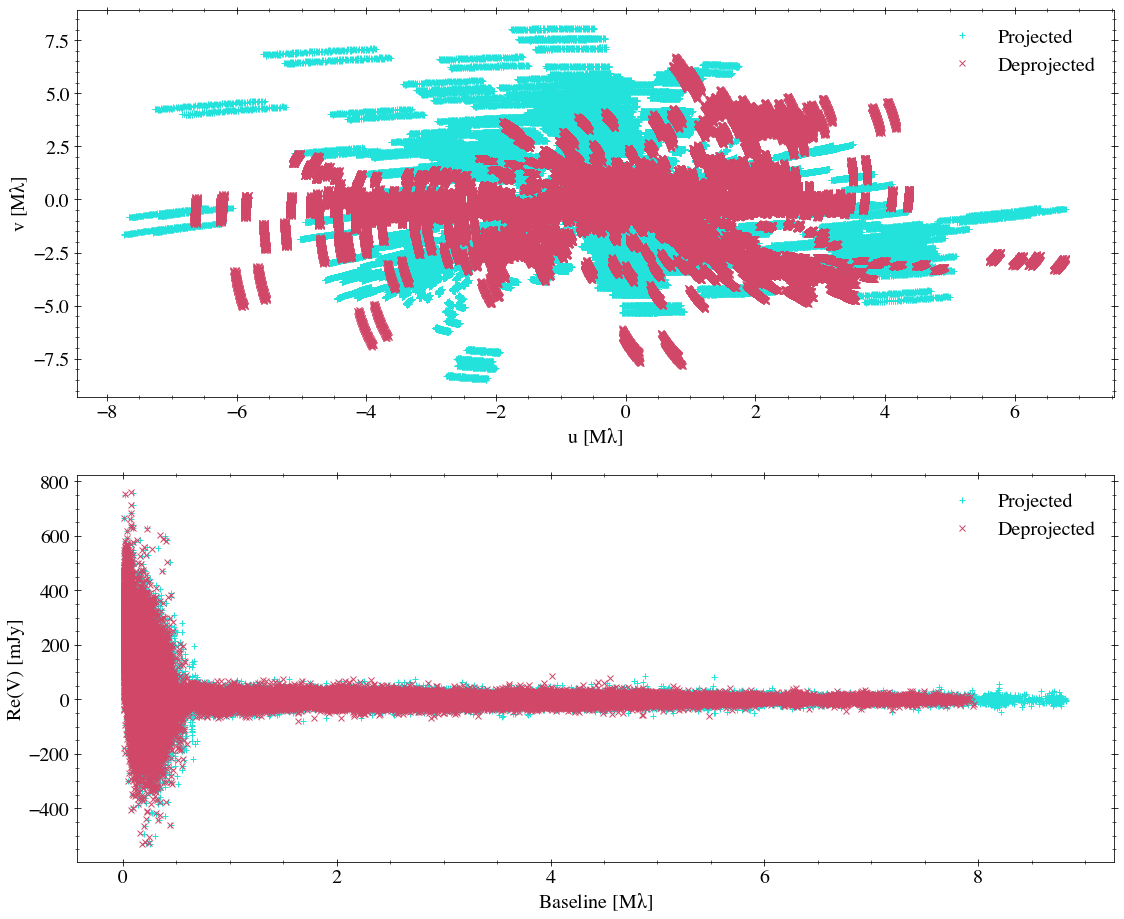

In [5]:
make_deprojection_fig(u, v, vis, weights, geom, bin_widths=[], figsize=(16,14), force_style=False);

### 2.1 Adding your own geometry fit routine 

You can extend frank's geometry fitting capabilities with your own routines by writing a class that inherits from the [SourceGeometry](../py_API.rst#frank.geometry.SourceGeometry) base class. This base class provides the interface used by frank to deproject the visibilities, but you do need to implement your own [fit()](../py_API.rst#frank.geometry.SourceGeometry.fit) method. This method will be called internally by `FrankFitter` to determine the geometry.

The `fit()` method should set the attributes `_inc`,  `_PA`, `_dRA`, and `_dDec` -- in respective units of [deg], [deg], [arcsec], [arcsec] -- that are used by the
[apply_correction()](../py_API.rst#frank.geometry.SourceGeometry.apply_correction),
[undo_correction()](../py_API.rst#frank.geometry.SourceGeometry.undo_correction),
[deproject()](../py_API.rst#frank.geometry.SourceGeometry.deproject),
and
[reproject()](../py_API.rst#frank.geometry.SourceGeometry.reproject) methods.

## 3. Fit the deprojected visibilities for the brightness profile

Now that we have the deprojected visibilities, let's fit them.

Objects used to perform a fit are in the `FrankFitter` class. In addition to the the `geom` object detailed in Sec.2, five hyperparameters affect the fit: `Rmax` and `N`, which set the disc radius out to which the fit is performed and the number of collocation points used in the fit; and `alpha`, `p_0` and `weights_smooth`, the hyperprior parameters on the power spectrum prior. 
See the frank methods paper for an explanation and interpretation of these five hyperparameters, and [this tutorial](./prior_sensitivity.ipynb) for a demonstration of how to test their effect on a given fit.

frank performs a fit with the `FrankFitter` class' [fit()](../py_API.rst#frank.radial_fitters.FrankFitter.fit) function. Let's use this with the `geom` object we generated above using the published geometry values, `Rmax = 1.6"` appropriate for AS 209, `N = 250` to ensure we resolve narrow features in the brightness profile, and the default values `p_0 = 1e-15` Jy$^2$, `alpha = 1.05` and `weights_smooth = 1e-4`. Recall that we'll only fit the real component of the visibilities, as frank is assuming an axisymmetric source that has zero imaginary component.

In [6]:
Rmax, N, alpha, weights_smooth = 1.6, 250, 1.05, 1e-4

# Initialze the FrankFitter class
FF = FrankFitter(Rmax, N, geometry=geom, alpha=alpha, weights_smooth=weights_smooth)

# Fit the data, returning the maximum a posteriori solution object
sol = FF.fit(u, v, vis, weights)

  Fitting for brightness profile using FrankFitter
    Building visibility matrices M and j


    FrankFitter iteration 692

    Convergence criterion met at iteration 692


Once the fit is complete, the brightness profile's best fit parameters are returned and stored in the `FrankFitter` class' [MAP_solution](../py_API.rst#frank.radial_fitters.FrankFitter.MAP_solution) object (we called it `sol` above). This provides:

- the [maximum a posteriori solution](../py_API.rst#frank.radial_fitters.FrankGaussianFit.I) and posterior [covariance](../py_API.rst#frank.radial_fitters.FrankGaussianFit.covariance) for the reconstructed brightness profile; 
- the fit's radius points [r](../py_API.rst#frank.radial_fitters.FrankGaussianFit.r) and corresponding frequency points [q](../py_API.rst#frank.radial_fitters.FrankGaussianFit.q); 
- methods to compute the best fit model's visibilities at given (u, v) coordinates in either the sky plane with [predict](../py_API.rst#frank.radial_fitters.FrankGaussianFit.predict) or the deprojected plane with [predict_deprojected](../py_API.rst#frank.radial_fitters.FrankGaussianFit.predict_deprojected);
- and a method to evaluate the best fit model's [log_likelihood](../py_API.rst#frank.radial_fitters.FrankGaussianFit.log_likelihood).

Additionally the `FrankFitter` object we created (we called it `FF`) contains the power spectrum's best fit parameters:

- the maximum a posteriori power spectrum mean ([MAP_spectrum](../py_API.rst#frank.radial_fitters.FrankFitter.MAP_spectrum)) and covariance ([MAP_spectrum_covariance](../py_API.rst#frank.radial_fitters.FrankFitter.MAP_spectrum_covariance)).



## 4. Save the results and generate plots

We could now save the fit results, including the `sol` object, with `save_fit(u, v, vis, weights, sol, prefix='AS209_continuum')`. We could also produce a full diagnostic figure and/or simplified figure of the fit. But since we've already done all this in the [Quickstart](../quickstart.rst), let's instead use the `sol` object to make a figure comparing the frank fitted brightness profile to the published CLEAN image-extracted profile ([Huang et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..42H/abstract)). 

If running frank from the terminal, you can produce this figure by setting, in your parameter file, `compare_profile` to the path to a file with a CLEAN profile (or any comparison profile) and `clean_beam` to the beam parameters (FWHM along both axes, position angle).

    Making CLEAN comparison figure


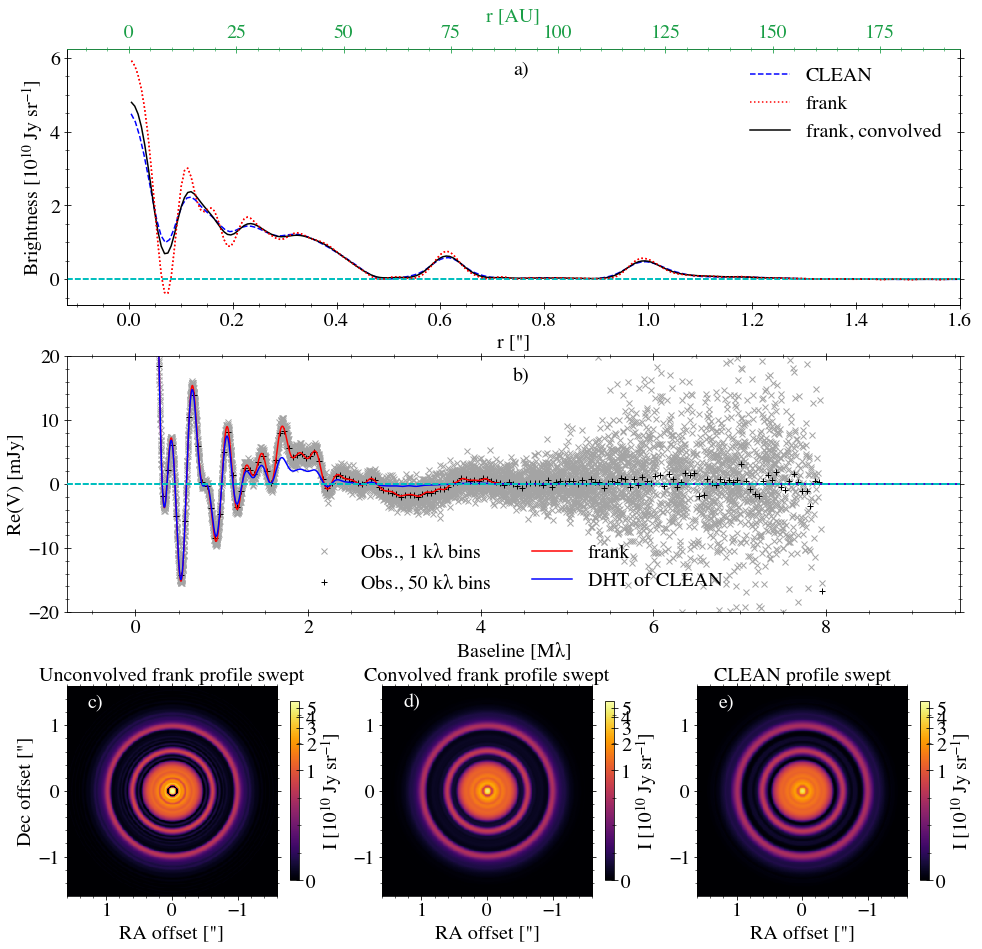

In [7]:
# Load the CLEAN radial profile for AS 209
r_clean, I_clean = np.genfromtxt('./AS209_clean_profile.txt').T
clean_profile = {'r':r_clean, 'I':I_clean, 'lo_err':None, 'hi_err':None}

# Using the same disc geometry parameters as above (the published values)
# and the CLEAN beam parameters from CASA (`imhead` of the published .fits file),
# convolve the frank profile with the CLEAN beam
# Units: [arcsec], [arcsec], [deg]
clean_beam = {'bmaj':0.03883, 'bmin':0.03818, 'beam_pa':85.82243}
mean_convolved = convolve_profile(sol.r, sol.mean, geom.inc, geom.PA, clean_beam)

# For the visibility plot, show the observations in 1 and 50 k\lambda bins
bin_widths = [1e3, 5e4]

# And for the 2D representations of the 1D profiles, use a colormap with an arcsinh 
# normalization, including a choice of the arcsinh scale parameter, 'asinh_a'
stretch = 'asinh'
asinh_a = 0.02

# Distance to source [pc] (Andrews et al. 2018), just to show a second x-axis in AU
dist = 121. 

# Zoom in on the lower amplitude visibilities to better see the fit accuracies at long baselines
ylims = [-20, 20]

make_clean_comparison_fig(u, v, vis, weights, sol, clean_profile,
                          bin_widths=bin_widths, stretch=stretch, mean_convolved=mean_convolved, 
                          dist=dist, ylims=ylims, force_style=False, figsize=(16,16));

**a)** The frank profile, this profile convolved with the CLEAN beam, and the CLEAN profile. The frank profile when convolved with the CLEAN beam is pretty similar to the CLEAN profile, an indication that the unconvolved frank profile is correctly identifying sub-beam structure. The observartions are shown in $1$ and $50$ k$\lambda$ bins.

**b)** The binned, observed visibilities, the frank visibility domain fit, and the discrete Hankel transform (DHT) of the CLEAN profile. Relative to the frank fit, the DHT of the CLEAN profile is low beyond $\approx 1\times 10^6 \lambda$, primarily because of beam convolution. This is another indication that the frank brightness profile is accurately recovering sub-beam structure.

**c)** The unconvolved frank profile swept over $2 \pi$ to generate a face-on, 2D representation of the 1D profile. Note this _is not_ an image generated by CLEANing the frank fitted visibilities. The colorscale is the same across (c) - (e) for comparison.

**d)** The frank profile convolved with the CLEAN beam, then swept over $2 \pi$. As expected, the 2D sweep has annular features that are less sharply defined that in (c) because convolving the frank profile effectively degrades its resolution.

**e)** The CLEAN profile swept over $2 \pi$. This is not the CLEANed observation, just a 2D representation of the CLEAN profile for comparison with (c) - (d).